In [71]:
# (Auto labeling with EM) In practice, availability of labelled datasets is difficult.
# One approach is to cluster the dataset suitably and then retrospectively assign
# label to each cluster. Using the approach described in Figure 9.10 of Bishop

# cluster the MNIST dataset into 10 clusters using mixture of bernoulli distribu-
# tions and then examine the average cluster. Thereafter, each cluster is labelled

# based on the average cluster. Record, how many points were misclassified based
# on this approach.

In [72]:
# import the mnist data set
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [73]:
df = pd.read_csv('mnist234.csv')
# drop the first column
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


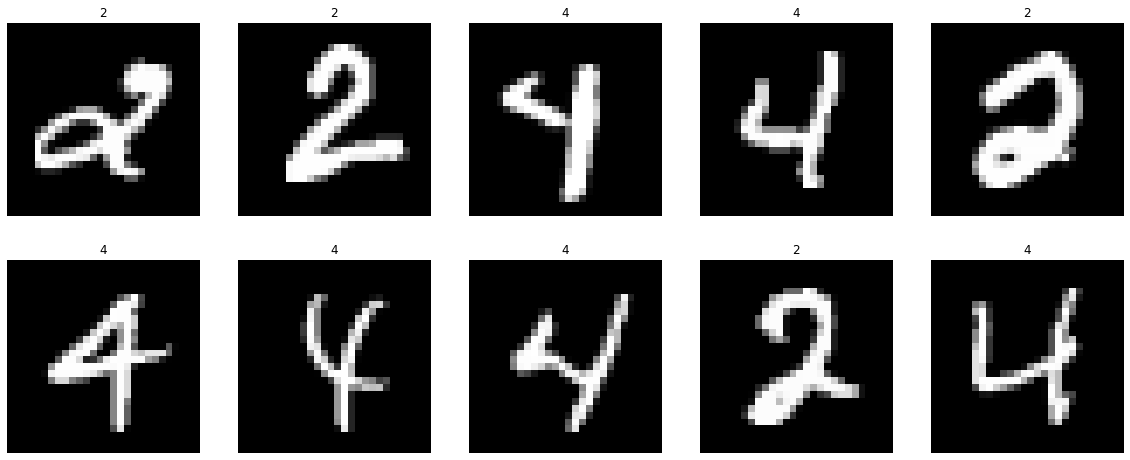

In [75]:
# lets see some sample images from the dataset
rand_index = np.random.randint(0, len(df), size=10)
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax[i // 5, i % 5].imshow(df.iloc[rand_index[i]][1:].values.reshape(28, 28), cmap='gray')
    ax[i // 5, i % 5].set_title(df.iloc[rand_index[i]][0])
    ax[i // 5, i % 5].axis('off')


In [76]:
# convert the features to 0 to 1
# 0 to 255/2 will be 0 while 255/2 to 255 will be 1
df.iloc[:, 1:] = df.iloc[:, 1:] // 128

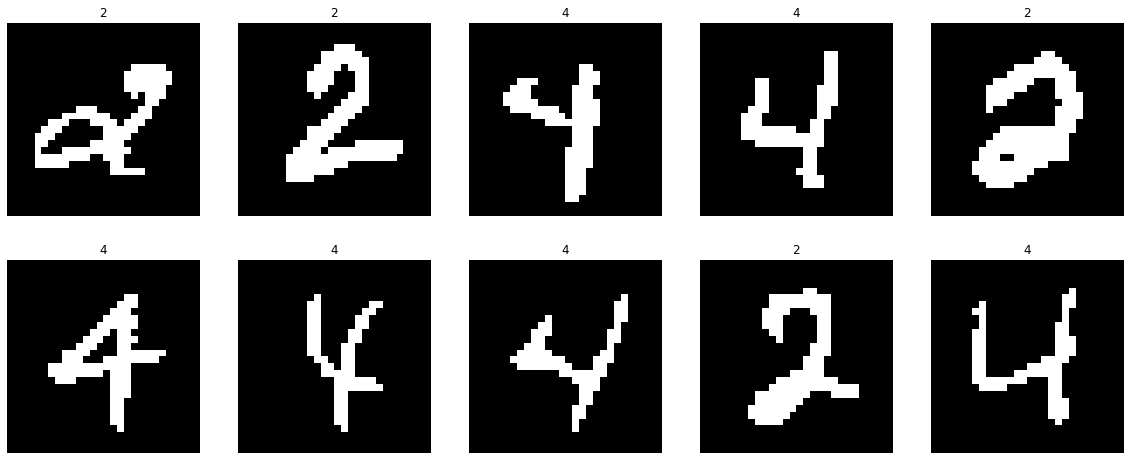

In [77]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax[i // 5, i % 5].imshow(df.iloc[rand_index[i]][1:].values.reshape(28, 28), cmap='gray')
    ax[i // 5, i % 5].set_title(df.iloc[rand_index[i]][0])
    ax[i // 5, i % 5].axis('off')


In [80]:
class BernouliMixture:
    def __init__(self):
        self.gamma = None
        self.mu = None
        self.pi = None
        self.k = None
        
    def gamma_nk(self, X, n, k):
        gamma = self.pi[k] * self.bernouli_pdf(X[n], self.mu[k])
        denom = 0
        for i in range(self.k):
            denom += self.pi[i] * self.bernouli_pdf(X[n], self.mu[i])
        if denom == 0:
            print('denom is zero')
            print(gamma, denom)
        return gamma / denom

    def N_k(self, X, k):
        N = X.shape[0]
        for i in range(X.shape[0]):
            N += self.gamma[i, k]
        return N

    def X_k(self, X, k):
        X_k = np.zeros(X.shape[1])
        for n in range(X.shape[0]):
            X_k += self.gamma[n, k] * X[n]
        return X_k / self.N_k(X, k)
        

    def Mu_k(self, X, k):
        mu_k = self.X_k(X, k)
        return mu_k

    def Pi_k(self, X, k):
        N_k = self.N_k(X, k)
        return N_k / X.shape[0]

    def bernouli_pdf(self, x, mu):
        pdf = 1
        for i in range(len(x)):
            pdf *= (mu[i] ** x[i]) * ((1 - mu[i]) ** (1 - x[i]))
        return pdf
    
    def fit(self, X, k, max_iter=10):
        self.k = k
        self.pi = np.ones(k) / k
        # initialize the mu between 0.25 and 0.75
        self.mu = np.random.uniform(0.25, 0.75, size=(k, X.shape[1]))
        # normalise the rows of mu
        self.mu = self.mu / np.linalg.norm(self.mu, axis=1).reshape(-1, 1)
        
        self.gamma = np.zeros((X.shape[0], k))
        
        for i in range(max_iter):
            for n in range(X.shape[0]):
                for k in range(self.k):
                    self.gamma[n, k] = self.gamma_nk(X, n, k)
            for k in range(self.k):
                self.mu[k] = self.Mu_k(X, k)
                self.pi[k] = self.Pi_k(X, k)
        return self
        
            
    
    

In [84]:
bmm = BernouliMixture()
# shuffle the data
np.random.seed(0)
shuffle_index = np.random.permutation(df.shape[0])
bmm.fit(df.iloc[0:100, 1:].values, 3)
mu = bmm.mu

In [85]:
print(mu.shape)

(3, 784)


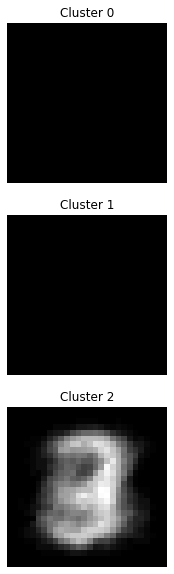

In [86]:
# plot mu for all three clusters
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
for i in range(3):
    ax[i].imshow(mu[i].reshape(28, 28), cmap='gray')
    ax[i].set_title('Cluster {}'.format(i))
    ax[i].axis('off')
    
